# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Yamin SEPEHRI, Asli YORUSUN
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [36]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

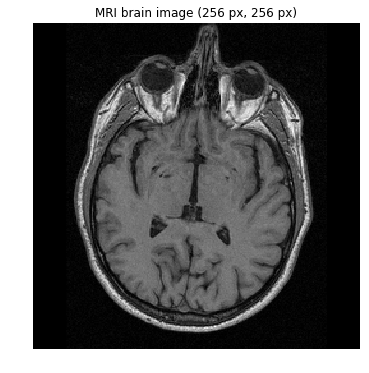

In [37]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Preprocessing

In the first step, we will perform a preprocessing on the image and the result will be used for all the different methods. In order to do so, we will first perform a median filter to remove the noise without a high blurring and after that, we will equalize the histogram of our image. We used OpenCV package for this reason. In each of the next parts, we may use each of these results or the original image based on the segementation method:

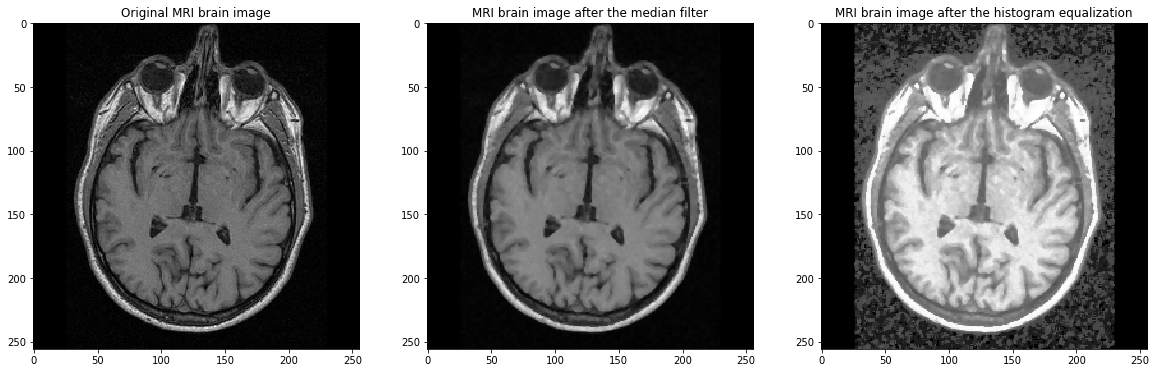

In [38]:
#Preprocessing

import cv2 # Imports the OpenCV library
import numpy as np #Imports the numPy Library
%matplotlib inline

# Performs the median filter based on 3 points
brain_im_medfil = cv2.medianBlur(brain_im,3) 

#Performs histogram equalization
brain_im_eqhist= cv2.equalizeHist(brain_im_medfil) 

#Plots the 3 images of the steps in the same row
fig, ax = plt.subplots(1, 3, figsize=(20, 6)) 

#Plotting the original image
ax[0].set_title("Original MRI brain image")
ax[0].imshow(brain_im, cmap='gray')

#Plotting the median filtered image
ax[1].set_title('MRI brain image after the median filter')
ax[1].imshow(brain_im_medfil , cmap='gray')

#Plotting the equalized histogram image
ax[2].set_title('MRI brain image after the histogram equalization')
ax[2].imshow(brain_im_eqhist, cmap='gray')

### 1.3 Region Growing

In this part, we will use the region growing method to perform the segmentation of the brain. The first step is to perform a seeding and it should be in the right region. After that, we begin to grow the region. Parallel to that, we check the contrast of the neighbor points to find the criteria of the brain segment. We tried to have the most simple and easily readable code and we just have a while loop.

The total area of brain is 16355 pixels from the region growing method.


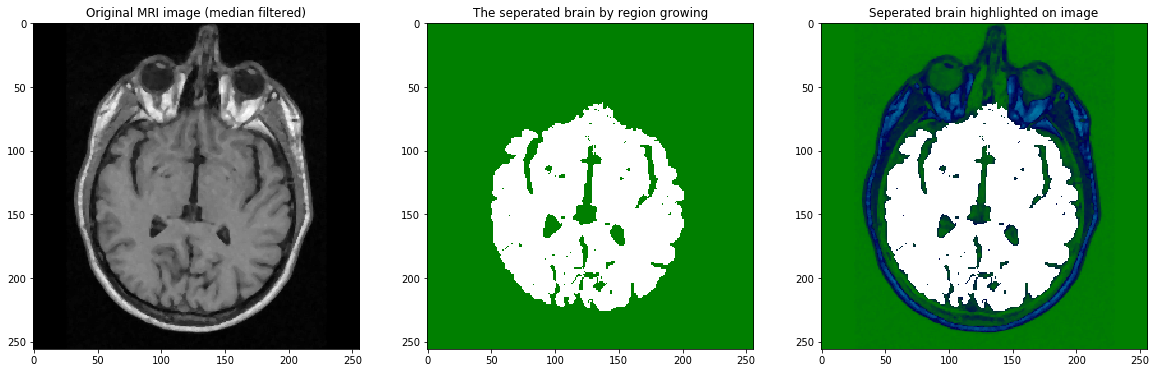

In [39]:
#Region Growing Method
#The median filtered figure was used for this part

img_ready=brain_im_medfil.copy() #Making a copy of image
threshold=6 #Setting the threshold of the contrast
seed=(157,157) #Seeding the first point
list_points=[]
finished_list=[]
list_points.append(seed)
region_growing_result=np.ones(img_ready.shape) #Making the raw matrix of seperated brain

while (len(list_points)>0):
    
    #The current point that will be checked is called the new seed
    new_seed=list_points[0]
    new_seed_x,new_seed_y=new_seed
    
    #Checking the threshold for the upper point 
    check_point= (new_seed_x,new_seed_y+1)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
        
    #Checking the threshold for the point on right
    check_point=(new_seed_x+1,new_seed_y)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
        
    #Checking the threshold for the point on left
    check_point=(new_seed_x-1,new_seed_y)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
        
    #Checking the threshold for the below point
    check_point=(new_seed_x,new_seed_y-1)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
    
    #Adding the current point to the final list of seperated points
    finished_list.append(new_seed)
    region_growing_result[new_seed]= 255
    
    #Remove the current point from check list
    list_points.pop(0)

#Printing the size of the brain
total_area = len(finished_list)
print('The total area of brain is {} pixels from the region growing method.'.format(total_area))

#Plotting the original image (with median filter)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].set_title("Original MRI image (median filtered)")
ax[0].imshow(brain_im_medfil, cmap='gray')

#Plotting the seperated area
region_growing_result= region_growing_result.astype(np.uint8)
ax[1].set_title("The seperated brain by region growing")
ax[1].imshow(region_growing_result, cmap='ocean')

#Highlighting the seperated brain on the original image
Highlighted_brain = brain_im_medfil | region_growing_result
ax[2].set_title("Seperated brain highlighted on image")
ax[2].imshow(Highlighted_brain , cmap='ocean' )   


### 1.4 Contour detection
Add your implementation and discussion

### 1.5 Additional method: Thersholding
In this part, we will perform the thresholding method to find the size of brain in pixels. As the binary thersholding cannot work perfectly well in this image, due to having the different intensities for different parts, we performed a trick. First we will perform a thresholding on the (median filtered) original image to find the white areas which are not a part of brain. After that we will perform the thresholding on the equlized histogram image to find all the area of the image which are not black. Finally, we will subtract the first result from the second result to get the brain. To smooth the result, some mathematical morphology will be done. For the thresholding part, we used the OpenCV library and for the morphology part, we used the scikit image library

The total area of brain is 15010 pixels from the thresholding method.


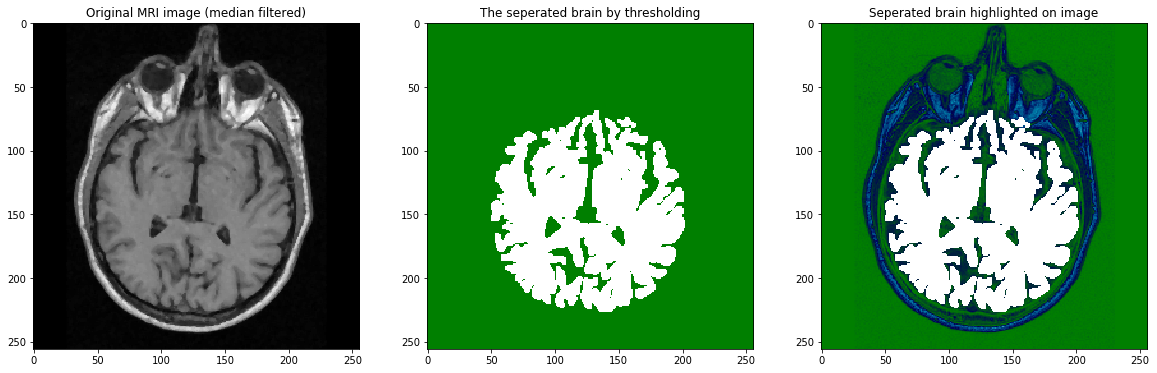

In [40]:
#Thresholding

#Importing the scikit image library
import skimage.morphology
from skimage.morphology import square

#Finding the white areas using a binary thresholding on equalized histogram image
_,all_the_white_areas= cv2.threshold(brain_im_eqhist,165,255,cv2.THRESH_BINARY)

#Finding the white areas which are not a part of image
#using a binary thresholding on original image
_,white_areas_which_are_not_the_brain= cv2.threshold(brain_im_medfil,99,255,cv2.THRESH_BINARY)

#Finding the brain itself
brain_im_thresholded =all_the_white_areas-white_areas_which_are_not_the_brain

#Performing mathematical morphology
brain_im_thresholded= skimage.morphology.binary_closing(brain_im_thresholded, selem = square(2), out=None)
brain_im_thresholded= skimage.morphology.remove_small_objects(brain_im_thresholded.astype(bool), min_size=900)
brain_im_thresholded= skimage.morphology.binary_erosion(brain_im_thresholded, selem=np.ones([2,2]))
brain_im_thresholded= skimage.morphology.binary_dilation(brain_im_thresholded, selem=np.ones([3,3]))

#Printing the size of the brain in pixels
thresholding_result= brain_im_thresholded.astype(np.uint8)
total_area = np.sum(thresholding_result)
print('The total area of brain is {} pixels from the thresholding method.'.format(total_area))

#Plotting the original image (median filtered)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].set_title("Original MRI image (median filtered)")
ax[0].imshow(brain_im_medfil, cmap='gray')

#Plotting the seperated area
thresholding_result=thresholding_result*255
ax[1].set_title("The seperated brain by thresholding")
ax[1].imshow(thresholding_result, cmap='ocean')

#Highlighting the seperated brain on the original image
Highlighted_brain = brain_im| thresholding_result
ax[2].set_title("Seperated brain highlighted on image")
ax[2].imshow(Highlighted_brain, cmap='ocean')


### 1.6 Additional method: Edge Detection
Add your implementation and discussion

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [41]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


FileNotFoundError: [Errno 2] No such file or directory: '../data/lab-01-data/varroa-01.jpg'

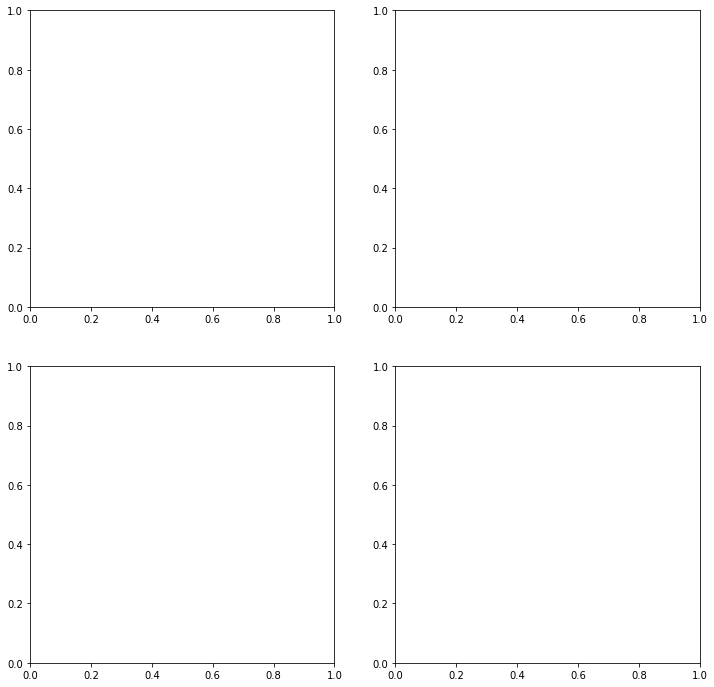

In [42]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [ ]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [ ]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]
`11`

In [ ]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion